This is needed to reload modules without restarting the kernel

In [1]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [2]:
import os
os.sys.path.append('../../')

# Trying to use a LightGBM for reweighting

In [3]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
f = uproot.open('/mnt/storage/lborgna/NNT/data17_with_weights.root')

In [6]:
df_cr = f['control'].pandas.df()

In [7]:
from eda_tools.NN_RW import nominal, louppe_loss, log_inputs, create_labels, NN

In [8]:
features_to_rw = nominal()

In [9]:
features_to_rw

{'rw_cols_to_log': ['pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'X_wt'],
 'rw_cols_log': ['pT_2_log',
  'pT_4_log',
  'eta_i',
  'dRjj_1_log',
  'dRjj_2_log',
  'njets',
  'pt_hh_log',
  'X_wt_log',
  'dR_hh',
  'dPhi_h1',
  'dPhi_h2']}

In [12]:
from eda_tools.utilities import calculatedPhi, calculatedRhh

In [13]:
calculatedPhi(df_cr)
calculatedRhh(df_cr)

In [14]:
log_inputs(df_cr, to_log=features_to_rw['rw_cols_to_log'])

In [15]:
rw_columns =features_to_rw['rw_cols_log']

In [16]:
train_size = df_cr.shape[0]

In [17]:
original = df_cr.loc[df_cr['ntag'] == 2, features_to_rw['rw_cols_log']]

In [18]:
target = df_cr.loc[df_cr['ntag']>=4, features_to_rw['rw_cols_log']]

In [19]:
X_all = pd.concat((original, target), ignore_index=True).values
Y_all = create_labels(original, target)

In [20]:
Y_all = Y_all.astype('float32')

In [21]:
scaler = StandardScaler()

In [22]:
X_train = scaler.fit_transform(X_all)
Y_train = Y_all.copy()

In [23]:
idx = np.random.permutation(X_train.shape[0])

In [24]:
idx.shape

(1768324,)

In [25]:
X_train = X_train[idx]
Y_train = Y_train[idx]

In [27]:
import lightgbm as lgb

In [30]:
d_train = lgb.Dataset(X_train, label = Y_train)

In [89]:
params = {}
params['learning_rate']=0.01
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=7
params['n_estimators'] = 500
params['is_unbalance'] = True
params['num_leaves'] = 50
params['verbose'] = 1

In [90]:
clf = lgb.train(params, d_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1738549, number of negative: 29775
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 1768324, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.983162 -> initscore=4.067137
[LightGBM] [Info] Start training from score 4.067137


In [72]:
y_pred = clf.predict(X_train)

In [73]:
pred = clf.predict(scaler.transform(df_cr.loc[df_cr.ntag==2, rw_columns].values))

In [74]:
df_cr.loc[df_cr.ntag==2, 'weight'] = (1-pred)/ pred

In [75]:
df_cr.fillna({"weight":1}, inplace =True)

In [76]:
mask2b = df_cr['ntag'] ==2
mask4b = df_cr['ntag'] >=4
maskCR = df_cr['kinematic_region']==2

In [77]:
norm = df_cr[mask4b].shape[0] / df_cr.loc[mask2b, 'weight'].sum()

In [78]:
norm

1.017426624672404

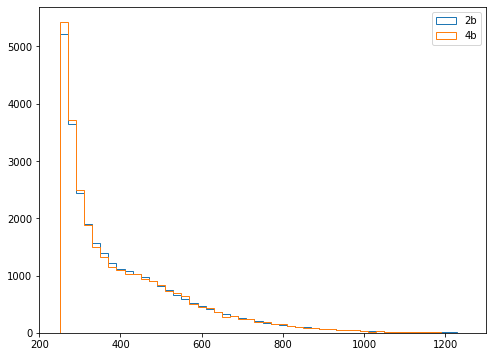

In [79]:
f, ax = plt.subplots(figsize=(8,6))
h2b, be, _ = plt.hist(
    df_cr.loc[mask2b, "m_hh_cor"].values,
    bins=50,
    histtype="step",
    range=(250, 1250),
    weights=norm*df_cr.loc[mask2b, "weight"].values,
    label="2b",
)
h4b, _, _ = plt.hist(
    df_cr.loc[mask4b, "m_hh_cor"].values, bins=be, histtype="step", label="4b"
)
plt.legend()

(-10.0, 10.0)

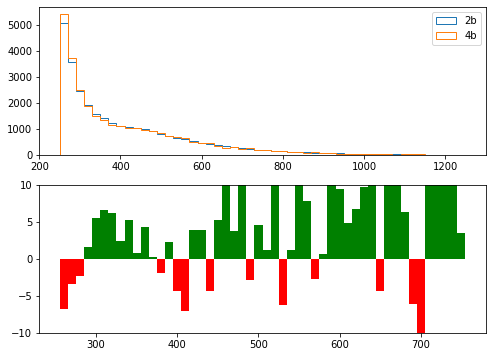

In [53]:
f, ax = plt.subplots(2, 1, figsize=(8,6))
h2b, be, _ = ax[0].hist(
    df_cr.loc[mask2b, "m_hh_cor"].values,
    bins=50,
    histtype="step",
    range=(250, 1250),
    weights=norm*df_cr.loc[mask2b, "weight"].values,
    label="2b",
)
h4b, _, _ = ax[0].hist(
    df_cr.loc[mask4b, "m_hh_cor"].values, bins=be, histtype="step", label="4b"
)
ax[0].legend()
percentages = 100 * (h2b-h4b)/h4b
x = 0.5*(be[:1]+be[1:])
width = x[1] - x[0]
#ax[1].bar(x, percentages, width=width)
ax[1].bar(x[percentages<0], percentages[percentages<0], color='red', width=width)
ax[1].bar(x[percentages>0], percentages[percentages>0], color='green', width=width)
ax[1].set_ylim(-10, 10)

In [82]:
clf.feature_importance()

array([2449, 2030,  966,  930, 1584, 1538, 1721, 1516,  868,  695,  703],
      dtype=int32)

# SHAP EXPLAINABILITY

In [226]:
X_train

array([[ 1.33520483, -0.91592952, -0.50574989, ...,  0.39213915,
        -1.60457223, -1.10669329],
       [ 1.39335967,  0.26500773, -0.59074104, ...,  0.54458543,
        -1.20578848, -1.28547205],
       [ 0.33548848, -0.85812125, -0.46083904, ...,  0.7082063 ,
         1.01351312,  0.07288921],
       ...,
       [ 0.36317595, -1.24274726,  0.84869292, ...,  0.12377528,
        -1.15409998,  0.76723113],
       [ 1.78489182, -0.17677873, -1.00965608, ...,  0.91368331,
        -0.54174375, -0.32445997],
       [ 0.29691962,  0.42485154, -0.19850847, ...,  0.0769238 ,
        -1.29479317, -1.35888231]])

In [55]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


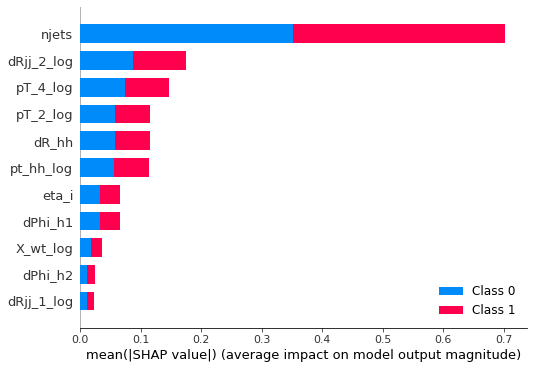

In [58]:
shap.summary_plot(shap_values, X_train, feature_names=features_to_rw["rw_cols_log"])